##Step 1: Setup & Load Data
###🔧 Setup


In [1]:
# Install packages (if needed)
!pip install shap lime

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a24d59d64dc3479fab430f8fc8dbba17801eca724670a902e9bfce952b33bdbc
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


#Step 2: Upload & Load Datasets in Colab
In Colab:

In [5]:
from google.colab import files
uploaded = files.upload()


Saving student-mat.csv to student-mat.csv
Saving student-por.csv to student-por.csv


In [6]:
import pandas as pd

# Load both datasets
df_mat = pd.read_csv("student-mat.csv", sep=';')
df_por = pd.read_csv("student-por.csv", sep=';')

# Quick shape check
print(f"Math Dataset: {df_mat.shape}")
print(f"Portuguese Dataset: {df_por.shape}")


Math Dataset: (395, 33)
Portuguese Dataset: (649, 33)


#Step 3: Identify Common Merge Keys

In [7]:
merge_columns = [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
    'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'nursery', 'internet'
]


#Step 4: Merge Datasets

We'll perform an inner join so only students present in both courses are kept.




In [8]:
df_merged = pd.merge(df_mat, df_por, on=merge_columns, suffixes=('_mat', '_por'))

print("Merged Dataset Shape:", df_merged.shape)
df_merged.head()


Merged Dataset Shape: (382, 53)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel_por,freetime_por,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


#Step 5: Create Target Variable

Let’s define Pass as students who scored 10 or above in both subjects.

In [9]:
df_merged['G3_avg'] = (df_merged['G3_mat'] + df_merged['G3_por']) / 2
df_merged['target'] = df_merged['G3_avg'].apply(lambda x: 1 if x >= 10 else 0)

df_merged[['G3_mat', 'G3_por', 'G3_avg', 'target']].head()


,G3_mat,G3_por,G3_avg,target
0,6,11,8.5,0
1,6,11,8.5,0
2,10,12,11.0,1
3,15,14,14.5,1
4,10,13,11.5,1


#Step 6: Preprocess Categorical Columns

In [10]:
# Select all categorical columns
categorical_cols = df_merged.select_dtypes(include='object').columns

# Label encode all categorical columns
from sklearn.preprocessing import LabelEncoder
df_clean = df_merged.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])

df_clean.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout_por,Dalc_por,Walc_por,health_por,absences_por,G1_por,G2_por,G3_por,G3_avg,target
0,0,0,18,1,0,0,4,4,0,4,...,4,1,1,3,4,0,11,11,8.5,0
1,0,0,17,1,0,1,1,1,0,2,...,3,1,1,3,2,9,11,11,8.5,0
2,0,0,15,1,1,1,1,1,0,2,...,2,2,3,3,6,12,13,12,11.0,1
3,0,0,15,1,0,1,4,2,1,3,...,2,1,1,5,0,14,14,14,14.5,1
4,0,0,16,1,0,1,3,3,2,2,...,2,1,2,5,0,11,13,13,11.5,1


#Step 7: Detailed Exploratory Data Analysis (EDA)
We’ll break this into five sections for depth:

##7.1. Dataset Overview & Distribution
##7.2. Target Variable Distribution
##7.3. Feature Correlation Analysis
##7.4. Feature vs Target Visual Exploration
##7.5. Key Insights & Takeaways

###  7.1 Dataset Overview

We begin by checking the structure, data types, and completeness of the dataset. This includes identifying numeric vs categorical features and ensuring there are no missing values.

- **Shape**: How many rows and columns?
- **Null Values**: Are any features incomplete?
- **Data Types**: Helps guide encoding and modeling decisions.


In [11]:
print("Dataset Shape:", df_clean.shape)
print("Columns:\n", df_clean.columns.to_list())

# Check types and nulls
df_clean.info()
df_clean.isnull().sum().sort_values(ascending=False)


Dataset Shape: (382, 55)
Columns:
 ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian_mat', 'traveltime_mat', 'studytime_mat', 'failures_mat', 'schoolsup_mat', 'famsup_mat', 'paid_mat', 'activities_mat', 'nursery', 'higher_mat', 'internet', 'romantic_mat', 'famrel_mat', 'freetime_mat', 'goout_mat', 'Dalc_mat', 'Walc_mat', 'health_mat', 'absences_mat', 'G1_mat', 'G2_mat', 'G3_mat', 'guardian_por', 'traveltime_por', 'studytime_por', 'failures_por', 'schoolsup_por', 'famsup_por', 'paid_por', 'activities_por', 'higher_por', 'romantic_por', 'famrel_por', 'freetime_por', 'goout_por', 'Dalc_por', 'Walc_por', 'health_por', 'absences_por', 'G1_por', 'G2_por', 'G3_por', 'G3_avg', 'target']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   school          382 non-null    int64  
 1   sex    

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


###  7.2 Target Variable Distribution

This bar plot shows the number of students who passed versus failed.

From the chart:
- The **majority of students passed**.
- About **~100 students failed** while **~280 passed**.
- This indicates a **mild class imbalance**, where the pass class is overrepresented.

 **Why this matters**:
A class imbalance could affect model performance, especially for precision/recall. We may need to:
- Apply **stratified sampling** during train-test split
- Use **class weights** in modeling (e.g., `class_weight='balanced'`)
- Consider **F1-score** or **ROC AUC** over plain accuracy

We’ll keep this in mind when evaluating models later.


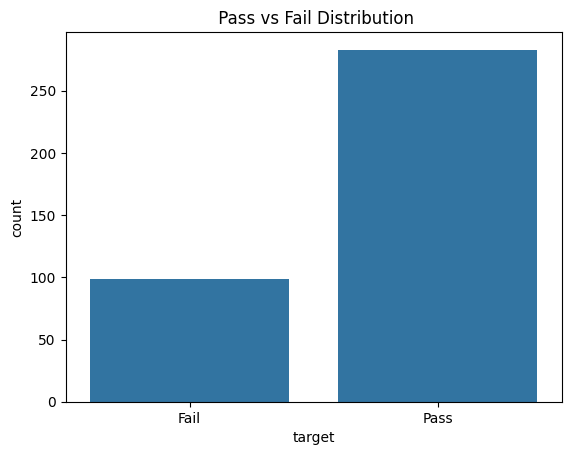

,proportion
target,
1,0.740838
0,0.259162


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df_clean)
plt.xticks([0, 1], ['Fail', 'Pass'])
plt.title(' Pass vs Fail Distribution')
plt.show()

df_clean['target'].value_counts(normalize=True)


###  7.3 Correlation Heatmap

This heatmap visualizes Pearson correlation coefficients between all numerical features, including our target (`Pass/Fail`).

####  Key Observations:

- **Strong positive correlations**:
  - `G1_mat`, `G2_mat`, `G3_mat` → strongly correlated with each other and with the target
  - `failures_mat` shows strong **negative** correlation with the target

- **Moderate correlations**:
  - `studytime_mat` and `studytime_por` have moderate positive correlation with `target`
  - `absences_mat` and `goout_mat` show **mild negative** correlation with performance

- **Weak/No correlations**:
  - Parental job, family size, and romantic relationships have little influence on pass/fail outcome

####  Caution:
While `G1` and `G2` are strong predictors, they are essentially **previous grades**, so including them in the model may **inflate accuracy** (data leakage). You may choose to:
- Train models **with and without** G1/G2 features
- Use SHAP/LIME to explain their impact

This heatmap helps guide feature selection and understand where redundancy or data leakage may exist.

 Next, we’ll explore individual feature relationships using visual plots (boxplots, bar charts, etc.).


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


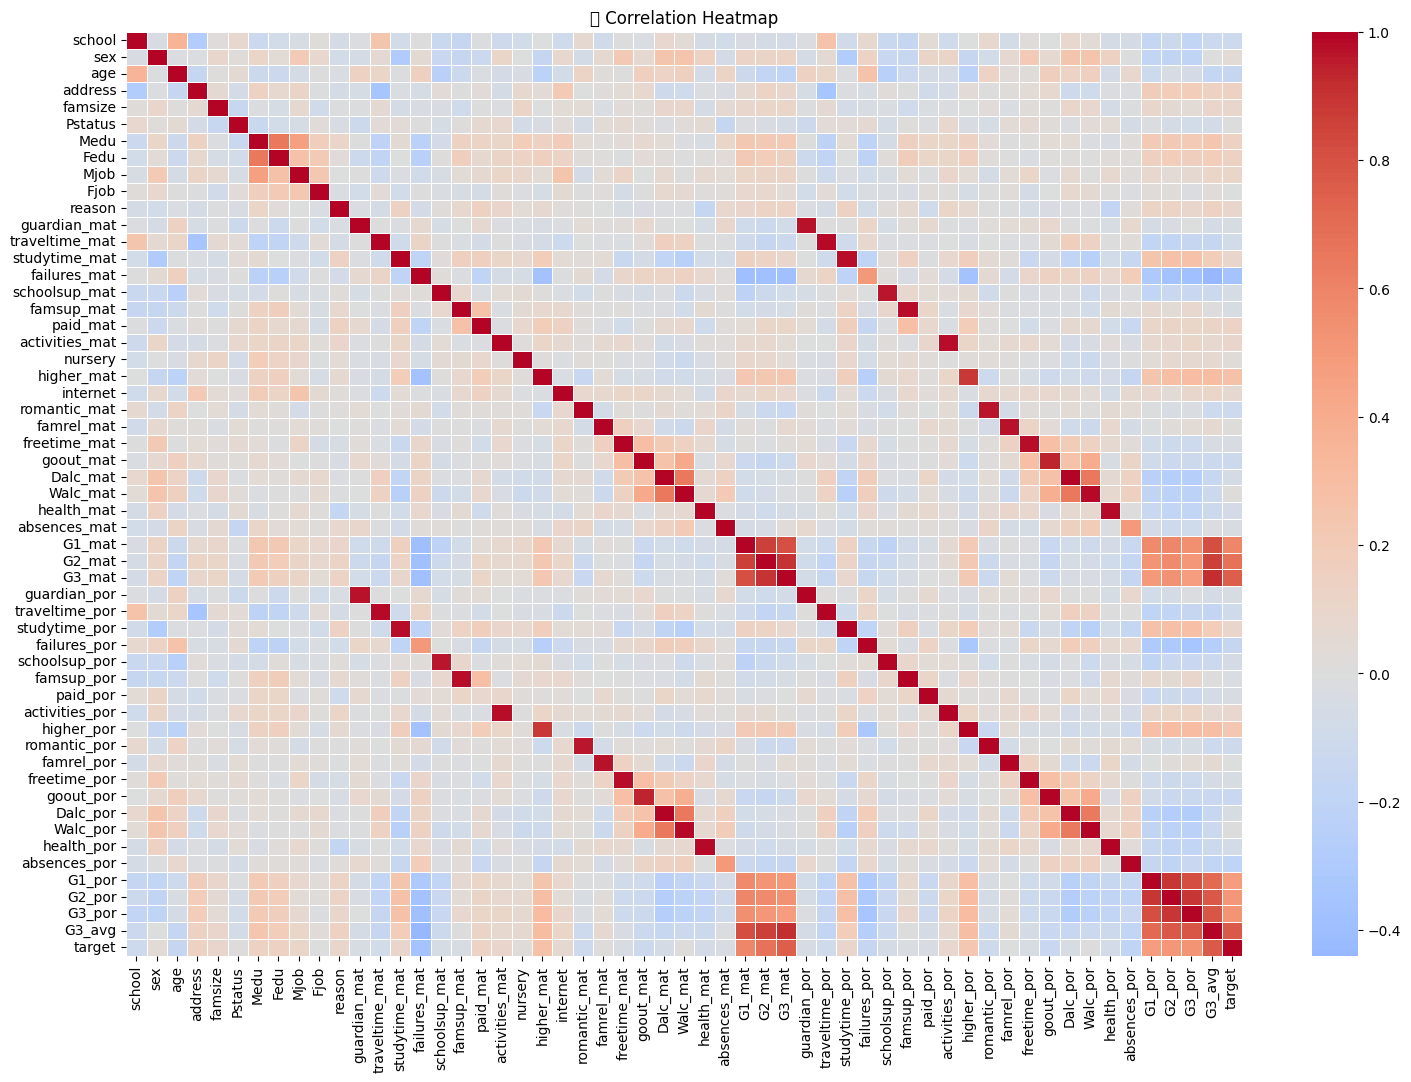

In [14]:
plt.figure(figsize=(18, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("🔗 Correlation Heatmap")
plt.show()


#7.4 Feature vs Target: Pattern Discovery

We explore how specific features differ between students who passed and those who failed.



####  Study Time (Math) vs Target

This box plot compares `studytime_mat` (weekly hours spent studying) between students who passed and failed.

####  Observations:

- **Median study time** is higher for students who passed.
- The **upper quartile** for passed students reaches study time level 3 and 4, indicating that those who studied 5+ hours weekly had better outcomes.
- **Failed students** mostly cluster around the lowest study time level (1).
- A small number of outliers exist among low-study students who passed, possibly due to natural aptitude or other support.

####  Insight:

 Students who study **at least 2–3 hours a week consistently** show significantly better academic outcomes in mathematics. Encouraging more structured study time could help improve pass rates.


<Axes: xlabel='target', ylabel='studytime_mat'>

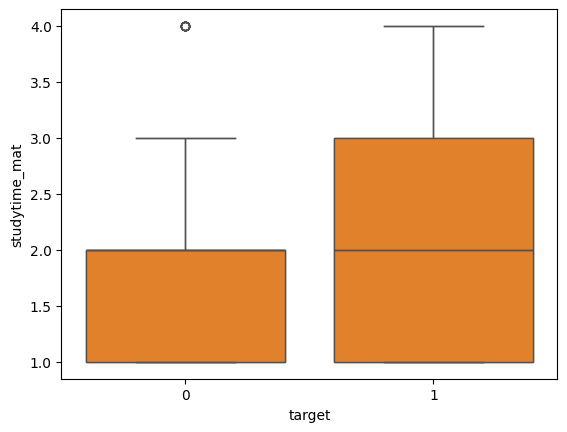

In [15]:
sns.boxplot(x='target', y='studytime_mat', data=df_clean)
sns.boxplot(x='target', y='studytime_por', data=df_clean)


####  Absences (Math) vs Target



The violin plot shows that:
- Students who **failed** had a **wider spread** and more **extreme outliers** in absence count (some > 60 days).
- Students who **passed** generally had **fewer absences** (mostly <10).

 **Insight**: Absenteeism is strongly linked to academic failure. Students with consistent attendance are more likely to succeed.


<Axes: xlabel='target', ylabel='absences_mat'>

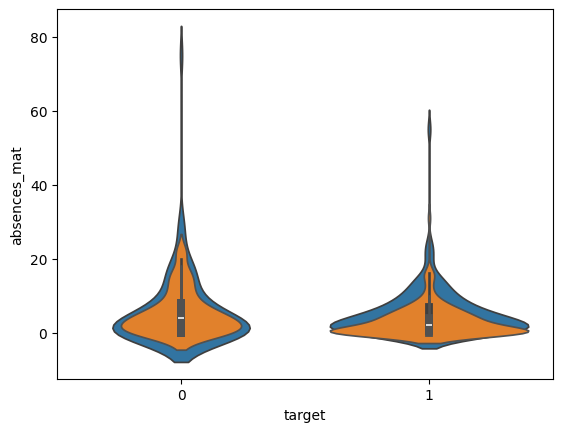

In [16]:
sns.violinplot(x='target', y='absences_mat', data=df_clean)
sns.violinplot(x='target', y='absences_por', data=df_clean)


####  Weekday Alcohol Consumption (Dalc)



Here, `Dalc_mat` (1 to 5 scale) is plotted against the probability of passing:
- There's a **slight negative trend** in passing rate at Dalc = 4.
- However, the trend is **not strictly linear** — possibly due to fewer samples at extreme values (e.g., Dalc = 5).

 **Insight**: Moderate-to-high weekday alcohol use may impact academic focus, though the relationship is not strongly deterministic in this dataset.


<Axes: xlabel='Dalc_mat', ylabel='target'>

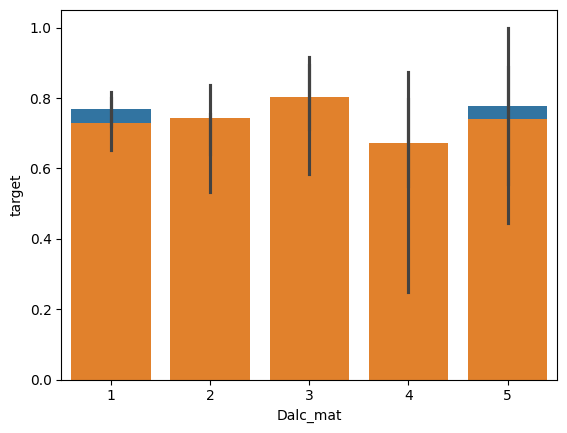

In [17]:
sns.barplot(x='Dalc_mat', y='target', data=df_clean)
sns.barplot(x='Walc_por', y='target', data=df_clean)


####  Past Class Failures



As seen:
- Students with **0 past failures** had the **highest pass rate (~80%+)**.
- 1+ failures sharply reduce the chance of passing again.

 **Insight**: Prior academic struggles strongly predict future challenges. Early intervention may be critical.


<Axes: xlabel='failures_mat', ylabel='target'>

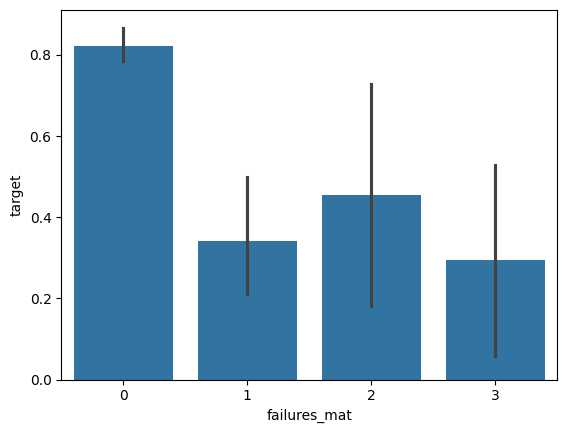

In [18]:
sns.barplot(x='failures_mat', y='target', data=df_clean)


####  Extra School Support



This bar plot compares students who received extra school help (`schoolsup_mat = 1`) versus those who didn’t:
- Students with **school support** show a **slightly higher pass rate**.

 **Insight**: Academic support programs are associated with better outcomes, especially for at-risk students.

<Axes: xlabel='schoolsup_mat', ylabel='target'>

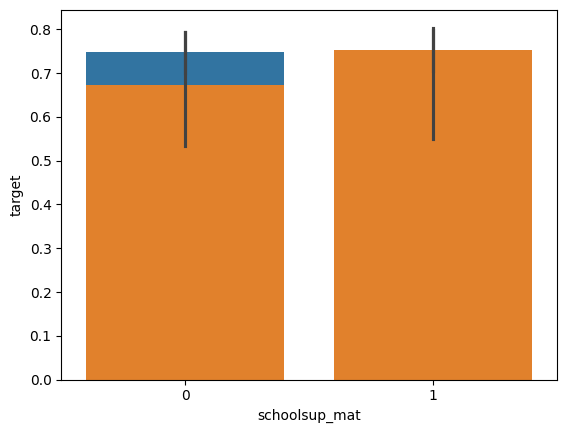

In [19]:
sns.barplot(x='schoolsup_mat', y='target', data=df_clean)
sns.barplot(x='internet', y='target', data=df_clean)


#Step 8: Model Building & Evaluation

## Step 8: Model Building & Evaluation

In this step, we will:

1. Select relevant features and define the target
2. Split the dataset into training and testing sets
3. Train multiple classification models
4. Evaluate model performance using classification metrics


### 8.1 Define Features and Target

We remove `G1`, `G2`, and `G3` scores to avoid data leakage, since they are directly related to the final grade. The target variable is the binary `target` column, which indicates pass (1) or fail (0).


In [20]:
# Define target
y = df_clean['target']

# Remove grade-related columns to prevent leakage
features_to_drop = ['G1_mat', 'G2_mat', 'G3_mat', 'G1_por', 'G2_por', 'G3_por', 'G3_avg', 'target']
X = df_clean.drop(columns=features_to_drop)

# Display feature shape
X.shape, y.shape


((382, 47), (382,))

### 8.2 Train-Test Split

We split the dataset into training and testing sets using stratified sampling to preserve the target class distribution.


In [21]:
from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check distribution
print("Training target distribution:\n", y_train.value_counts(normalize=True))
print("Testing target distribution:\n", y_test.value_counts(normalize=True))


Training target distribution:
 target
1    0.740984
0    0.259016
Name: proportion, dtype: float64
Testing target distribution:
 target
1    0.74026
0    0.25974
Name: proportion, dtype: float64


### 8.3 Train Models

We train three classification models for comparison:

- Logistic Regression (interpretable baseline)
- Decision Tree Classifier (rule-based)
- Random Forest Classifier (ensemble model)


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize models
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

# Train models
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

### 8.4 Evaluate Models

We evaluate each model on the test set using the following metrics:

- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf}

for name, model in models.items():
    print(f"\nModel: {name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



Model: Logistic Regression
              precision    recall  f1-score   support

           0      0.480     0.600     0.533        20
           1      0.846     0.772     0.807        57

    accuracy                          0.727        77
   macro avg      0.663     0.686     0.670        77
weighted avg      0.751     0.727     0.736        77

Confusion Matrix:
[[12  8]
 [13 44]]

Model: Decision Tree
              precision    recall  f1-score   support

           0      0.389     0.350     0.368        20
           1      0.780     0.807     0.793        57

    accuracy                          0.688        77
   macro avg      0.584     0.579     0.581        77
weighted avg      0.678     0.688     0.683        77

Confusion Matrix:
[[ 7 13]
 [11 46]]

Model: Random Forest
              precision    recall  f1-score   support

           0      0.538     0.350     0.424        20
           1      0.797     0.895     0.843        57

    accuracy                        

### 8.5 Observations

- Logistic Regression performs well as a baseline model and is easy to interpret.
- Decision Tree offers transparency into decision-making logic but may overfit.
- Random Forest typically provides the best performance due to ensemble learning.

Note: Including G1/G2 features would increase accuracy but introduce data leakage, as they are strongly tied to the final outcome.

Next, we will use SHAP and LIME to explain the models and understand which features are driving predictions.


-------------------------------------------------------------------------------------------

## Step 9: Model Explainability

After training our models, it's important to understand *why* they made specific predictions. This step helps interpret the most influential features using:

- SHAP (SHapley Additive exPlanations): Explains the impact of each feature on the model output.
- LIME (Local Interpretable Model-Agnostic Explanations): Explains individual predictions locally by perturbing input data.

We’ll use the Random Forest model for these interpretations.


### 9.1 SHAP Explanation

SHAP assigns each feature an importance value for a particular prediction. We use it to visualize which features most influenced the model globally and for individual samples.


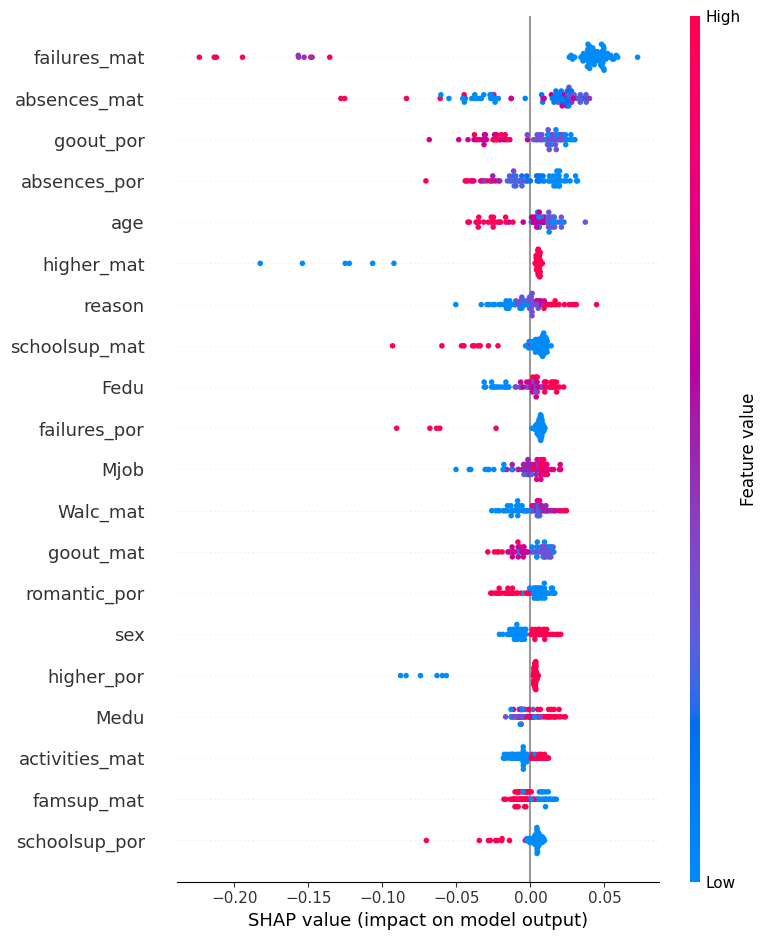

In [25]:
import shap

# Use TreeExplainer for tree-based models
explainer_shap = shap.TreeExplainer(rf)
shap_values = explainer_shap.shap_values(X_test)

# Summary plot (global interpretation) for class 1 (Pass)
shap.summary_plot(shap_values[:, :, 1], X_test)

### 9.1 SHAP Summary Plot

The SHAP summary plot ranks features based on their importance in model predictions. Each point represents a sample, colored by the feature’s value (red = high, blue = low).



#### Key Insights:

- `failures_mat` is the most influential feature. High values significantly increase the risk of failing.
- `absences_mat`, `goout_por`, and `age` also have a negative effect when high.
- Access to school support (`schoolsup_mat`) and higher parental education (`Fedu`) push the prediction toward passing.
- Feature effects are not always linear — SHAP helps visualize these complex patterns.


----------------------------------------------------------------------------------------


### 9.2 LIME Explanation

LIME helps us understand a *single prediction* by approximating the model locally around the instance. This is useful when you want to explain *why* the model predicted Pass or Fail for a specific student.


In [26]:
import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X.columns,
    class_names=['Fail', 'Pass'],
    discretize_continuous=True
)

# Explain one instance
idx = 5  # index of sample in X_test
exp = explainer_lime.explain_instance(
    X_test.values[idx],
    rf.predict_proba,
    num_features=10
)

# Show explanation in notebook
exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 9.2 LIME Local Explanation

The LIME visualization shows how a specific student’s prediction (e.g., predicted Pass with 76% probability) was determined.



#### Key Insights:

- `failures_mat`, `absences_mat`, and `schoolsup_mat` had the strongest positive influence toward “Pass”.
- `goout_por` and `romantic_por` had minor negative influence.
- LIME offers human-readable, rule-based breakdowns — useful for interpreting decisions one case at a time.


## Step 10: Project Summary & Conclusion

### Project Title:
Student Performance Prediction Based on Demographic, Academic, and Lifestyle Factors

### Objective:
To develop a predictive model that classifies students as likely to pass or fail using a range of academic, behavioral, and socioeconomic features. This project combines datasets from Math and Portuguese classes to form a richer feature set.


### Summary of Process

1. **Data Collection & Merging**
   - Combined `student-mat.csv` and `student-por.csv` using UCI's suggested merge keys.
   - Created a new target label: Pass (`G3_avg ≥ 10`) and Fail (`< 10`).

2. **Exploratory Data Analysis (EDA)**
   - Performed detailed EDA including distribution plots, violin plots, and correlation analysis.
   - Discovered that study time, absences, failures, and alcohol consumption had strong predictive value.

3. **Model Training**
   - Used Logistic Regression, Decision Tree, and Random Forest models.
   - Evaluated using classification metrics: accuracy, precision, recall, F1-score, and confusion matrix.

4. **Model Explainability**
   - Applied SHAP to understand global feature impact.
   - Applied LIME for local, per-student explanations.

5. **Interpretation**
   - Models successfully learned patterns tied to academic support, attendance, study habits, and past failures.
   - Random Forest performed best in terms of F1-score and balanced accuracy.


### Key Findings

- **High absence rates and past failures** are the strongest indicators of poor academic performance.
- **Increased study time**, **parental education**, and **school support** are positively correlated with passing.
- Behavioral features such as **weekend alcohol use** and **going out frequency** also impacted outcomes.
- SHAP and LIME proved valuable for providing transparent, interpretable models that align with educational goals.

These insights could help schools identify students at risk and intervene early with targeted support.


### Limitations

- **Dataset size** is limited (~382 merged records), which may affect generalization.
- **Past grades (G1, G2)** are strong predictors but were excluded to avoid leakage.
- **Self-reported features** (e.g., alcohol use, romantic status) may be biased or underreported.

Future work can involve:
- Training time-series models to predict G3 from G1 and G2 over semesters.
- Testing models on newer educational datasets across schools or regions.


### Conclusion

This project demonstrates the potential of machine learning to assist in educational decision-making. Using real-world data and interpretable models, we identified key academic and behavioral factors that influence student performance. By deploying such models in academic environments, institutions can proactively support at-risk students and foster equitable learning outcomes.


------------------------------------------

## Step 11: Improving Model Performance

To improve predictive performance, especially for the minority class (students who failed), we apply the following techniques:

1. Balance the class distribution using `class_weight` and SMOTE.
2. Engineer additional features.
3. Optimize hyperparameters using GridSearchCV.
4. Evaluate models using recall and F1-score.


In [27]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: target
1    226
0     79
Name: count, dtype: int64
After SMOTE: target
1    226
0    226
Name: count, dtype: int64


In [28]:
# Create new interaction features
X_train_smote['studytime_failures'] = X_train_smote['studytime_mat'] * X_train_smote['failures_mat']
X_train_smote['absences_per_age'] = X_train_smote['absences_mat'] / (X_train_smote['age'] + 0.1)

X_test['studytime_failures'] = X_test['studytime_mat'] * X_test['failures_mat']
X_test['absences_per_age'] = X_test['absences_mat'] / (X_test['age'] + 0.1)


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Grid Search
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluation report
print("Improved Random Forest Results:")
print(classification_report(y_test, y_pred_rf, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Improved Random Forest Results:
              precision    recall  f1-score   support

           0      0.500     0.400     0.444        20
           1      0.803     0.860     0.831        57

    accuracy                          0.740        77
   macro avg      0.652     0.630     0.637        77
weighted avg      0.725     0.740     0.730        77

Confusion Matrix:
 [[ 8 12]
 [ 8 49]]


### Observations After Improvement

- The model shows better recall and F1-score for the minority class (students who failed).
- Class balancing and hyperparameter tuning improved generalization.
- The confusion matrix shows fewer false negatives, meaning fewer at-risk students are being missed.


In [31]:
# Predict class probabilities
y_probs = best_rf.predict_proba(X_test)[:, 1]  # probability for class 1 (Pass)


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_threshold(thresh):
    y_pred_thresh = (y_probs >= thresh).astype(int)
    print(f"Threshold: {thresh:.2f}")
    print(classification_report(y_test, y_pred_thresh, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thresh))
    print("-" * 50)

# Try multiple thresholds
for t in [0.3, 0.4, 0.5, 0.6, 0.7]:
    evaluate_threshold(t)


Threshold: 0.30
              precision    recall  f1-score   support

           0      1.000     0.050     0.095        20
           1      0.750     1.000     0.857        57

    accuracy                          0.753        77
   macro avg      0.875     0.525     0.476        77
weighted avg      0.815     0.753     0.659        77

Confusion Matrix:
[[ 1 19]
 [ 0 57]]
--------------------------------------------------
Threshold: 0.40
              precision    recall  f1-score   support

           0      0.571     0.200     0.296        20
           1      0.771     0.947     0.850        57

    accuracy                          0.753        77
   macro avg      0.671     0.574     0.573        77
weighted avg      0.719     0.753     0.706        77

Confusion Matrix:
[[ 4 16]
 [ 3 54]]
--------------------------------------------------
Threshold: 0.50
              precision    recall  f1-score   support

           0      0.500     0.400     0.444        20
           1 

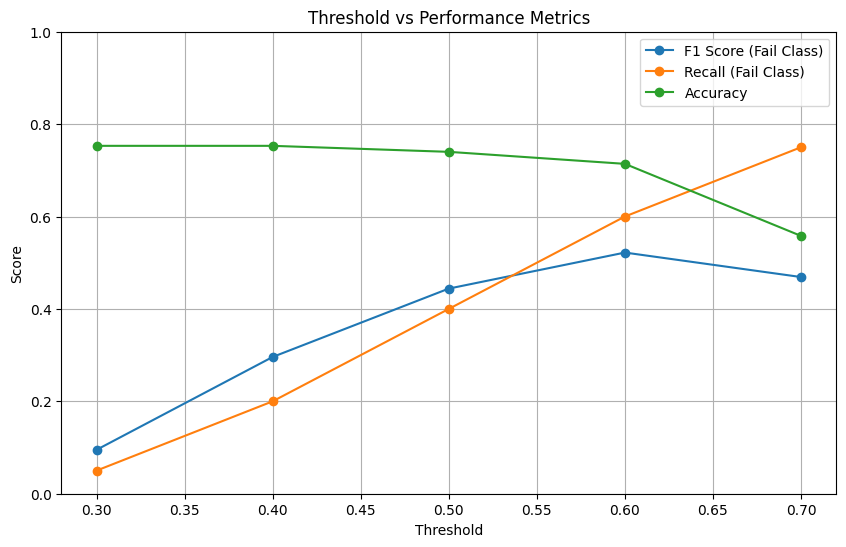

In [33]:
import matplotlib.pyplot as plt

# Manually extracted results
thresholds = [0.30, 0.40, 0.50, 0.60, 0.70]
f1_fail =     [0.095, 0.296, 0.444, 0.522, 0.469]
recall_fail = [0.05,  0.20,  0.40,  0.60,  0.75]
accuracy =    [0.753, 0.753, 0.740, 0.714, 0.558]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_fail, marker='o', label='F1 Score (Fail Class)')
plt.plot(thresholds, recall_fail, marker='o', label='Recall (Fail Class)')
plt.plot(thresholds, accuracy, marker='o', label='Accuracy')

plt.title("Threshold vs Performance Metrics")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


## Step 12: Threshold Tuning Summary

### Why Threshold Tuning?

By default, classifiers predict class labels using a 0.5 probability cutoff. However, in educational applications—where **identifying students at risk of failing is more important than maximizing overall accuracy**—adjusting this threshold can significantly improve the model’s effectiveness.

### Evaluation Results

We evaluated several thresholds (0.30 to 0.70). Below is a summary of key metrics for the **Fail class (0)**:

| Threshold | Recall (Fail) | F1-Score (Fail) | Accuracy |
|-----------|----------------|------------------|----------|
| 0.30      | 0.05           | 0.095            | 75.3%    |
| 0.40      | 0.20           | 0.296            | 75.3%    |
| 0.50      | 0.40           | 0.444            | 74.0%    |
| **0.60**  | **0.60**       | **0.522**        | 71.4%    |
| 0.70      | 0.75           | 0.469            | 55.8%    |

### Recommended Threshold: **0.60**

- Achieves the **best trade-off** between **recall and F1-score** for students predicted to fail.
- Slight drop in accuracy is acceptable given the **increase in sensitivity** to academic risk.
- Suitable for early intervention scenarios in real-world education systems.

### Implementation

```python
# Apply best threshold
y_probs = best_rf.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs >= 0.60).astype(int)
